In [1]:
import os
import logging
import sys

import numpy as np
from standard_tester import *

from runlmc.models.lmc import LMC, _LOG
_LOG.setLevel(logging.INFO)
logging.getLogger().handlers[0].stream = sys.stdout
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# as chosen in Nguyen 2014
ks = [RBF(name='rbf0')]
ranks = [2]
# the columns with nonzero test holdout are in test_fx
xss, yss, test_xss, test_yss, test_fx, cols = foreign_exchange_2007()

In [3]:
llgp_time, llgp_smse, llgp_nlpd, lmc = runlmc(
    1, None, xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 100, 'verbosity': 20})
print('time', llgp_time, 'smse', llgp_smse, 'nlpd', llgp_nlpd)

INFO:runlmc.models.lmc:LMC lmc generating inducing grid n = 3054
INFO:runlmc.models.lmc:LMC lmc grid (n = 3054, m = 238) complete, 
INFO:runlmc.models.lmc:LMC lmc fully initialized
starting adadelta {'momentum': 0.5, 'max_it': 100, 'decay': 0.9, 'step_rate': 1, 'roll': 2, 'min_grad_ratio': 0.5, 'verbosity': 20, 'offset': 0.0001}
iteration        5 grad norm 2.2796e+02
iteration       10 grad norm 2.6322e+02
iteration       15 grad norm 1.5836e+02
iteration       20 grad norm 2.7646e+02
finished adadelta optimization
            23 iterations
    1.7531e+02 final grad norm
    1.3631e+02 final MA(2) grad norm
    3.3872e+02 max MA(2) grad norm
    norm used inf
INFO:runlmc.models.lmc:Using 4 processors in parallel for 150 on-the-fly variance predictions
time 21.806218015 smse 0.19349658205 nlpd -3.94570834239


In [4]:
# Interpolating points != inducing points, but might as well give
# both good settings for a pretty picture.
m = len(lmc.inducing_grid)
cogp_time, cogp_smse, cogp_nlpd, cogp_mu, cogp_var = cogp_fx2007(1, m)
print('m', m, 'time', cogp_time, 'smse', cogp_smse, 'nlpd', cogp_nlpd)

m 238 time 433.866231 smse 0.215264996527685 nlpd 0.957226108495893


In [7]:
all_xs = np.arange(min(xs.min() for xs in xss), max(xs.max() for xs in xss) + 1)
test_ix = {col: list(cols).index(col) for col in test_fx}
pred_xss = [all_xs if col in test_fx else np.array([]) for col in cols]
lmc.prediction = 'exact'
pred_yss, pred_vss = lmc.predict(pred_xss)
pred_yss = {col: ys for col, ys in zip(cols, pred_yss)}
pred_vss = {col: vs for col, vs in zip(cols, pred_vss)}

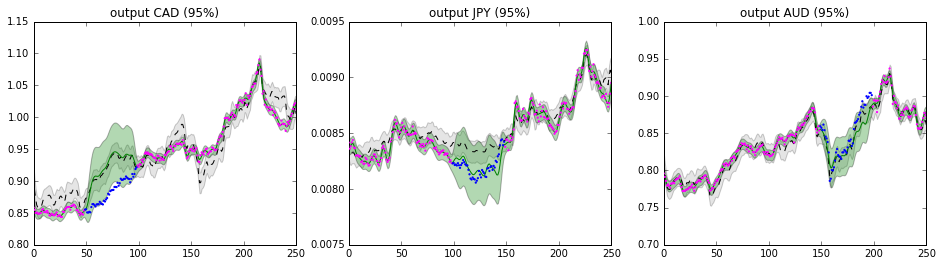

In [8]:
_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction on entire domain for COGP
    ax.plot(all_xs, cogp_mu[col], c='black', ls=':')
    sd = np.sqrt(cogp_var[col])
    top = cogp_mu[col] + 2 * sd
    bot = cogp_mu[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='grey', alpha=0.2)
    
    # Prediction for LLGP
    ax.plot(all_xs, pred_yss[col], c='green')
    sd = np.sqrt(pred_vss[col])
    top = pred_yss[col] + 2 * sd
    bot = pred_yss[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='green', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = test_xss[test_ix[col]]
    test_ys = test_yss[test_ix[col]]
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image (training)
    rest_xs = xss[test_ix[col]]
    rest_ys = yss[test_ix[col]]
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
        
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))


plt.show()

In [9]:
sum(map(len, xss)), sum(map(len, test_xss))

(3054, 150)

In [13]:
# warning: precompute takes a while, ~10 min on a 4-core 2015 laptop
methods = ['on-the-fly', 'exact', 'precompute']
results = []
for m in methods:
    lmc.prediction = m
    with contexttimer.Timer() as t:
        pred_yss, pred_vss = lmc.predict(test_xss)
    print('method {: <12} smse {:6.4f} nlpd {:13.4e} time {}'.format(
            m, 
            smse(test_yss, pred_yss, yss),
            nlpd(test_yss, pred_yss, pred_vss),
            t.elapsed))
    results.append(np.hstack(pred_vss))

INFO:runlmc.models.lmc:Using 4 processors in parallel for 150 on-the-fly variance predictions
method on-the-fly   smse 0.1935 nlpd   -3.9457e+00 time 25.68053933797637
method exact        smse 0.1935 nlpd   -3.9500e+00 time 0.12986565599567257
INFO:runlmc.models.lmc:Using 4 processors in parallel to precompute 3094 variance terms exactly
method precompute   smse 0.1935 nlpd   -3.9498e+00 time 425.2470513529843


In [16]:
onthefly, exact, precomp = results
def rel_norm_diff(exact, x):
    diff = np.linalg.norm(exact - x)
    orig = np.linalg.norm(exact)
    return diff / orig
print('on the fly ', rel_norm_diff(exact, onthefly))
print('precomputed', rel_norm_diff(exact, precomp))

on the fly  0.0058663940252
precomputed 0.000546462154322


In [17]:
n = len(lmc.y)
m = len(lmc.inducing_grid)
D = len(lmc.noise)
Q = len(lmc.kernels)
R = int(sum(ranks) / Q)
paramstr = 'n={},m={},D={},Q={},R={}'.format(n, m, D, Q, R)
paramstr

'n=3054,m=238,D=13,Q=1,R=2'

In [24]:
# warning: last one takes ~10 min on a 4-core 2015 laptop
samples = [100, 500, 1000]
samp_results = []
for s in samples:
    lmc.prediction = 'sample'
    lmc.variance_samples = s
    if 'sampled_nu' in lmc._cache:
        del lmc._cache['sampled_nu']
    with contexttimer.Timer() as t:
        pred_yss, pred_vss = lmc.predict(test_xss)
    print('method {: <12} smse {:6.4f} nlpd {:13.4e} time {}'.format(
            'sample {:5d}'.format(s), 
            smse(test_yss, pred_yss, yss),
            nlpd(test_yss, pred_yss, pred_vss),
            t.elapsed))
    samp_results.append(np.hstack(pred_vss))

INFO:runlmc.models.lmc:Using 1 processors in parallel to precompute 1 cholesky factors
INFO:runlmc.models.lmc:encountered incomplete rank 205 of 238 order kernel 0
INFO:runlmc.models.lmc:Using 4 processors in parallel to precompute 20 variance samples
warning, zero var found in predictive variance
method 238          smse 0.1935 nlpd   -1.9812e+00 time 8.30813984098495
INFO:runlmc.models.lmc:Using 1 processors in parallel to precompute 1 cholesky factors
INFO:runlmc.models.lmc:encountered incomplete rank 205 of 238 order kernel 0
INFO:runlmc.models.lmc:Using 4 processors in parallel to precompute 100 variance samples
warning, zero var found in predictive variance
method 238          smse 0.1935 nlpd   -1.4558e+00 time 41.13149821199477
INFO:runlmc.models.lmc:Using 1 processors in parallel to precompute 1 cholesky factors
INFO:runlmc.models.lmc:encountered incomplete rank 205 of 238 order kernel 0
INFO:runlmc.models.lmc:Using 4 processors in parallel to precompute 500 variance samples
w

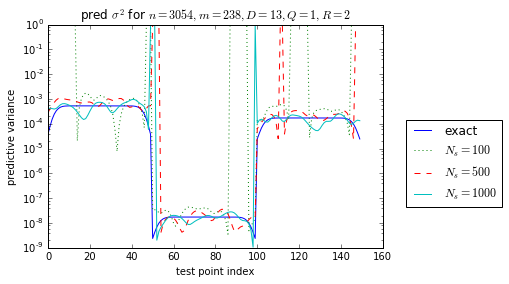

In [35]:
plt.semilogy(exact, label='exact')
lss = [':', '--', '-']
for ns, res, ls in zip(samples, samp_results, lss):
    plt.semilogy(res, label=r'$N_s={}$'.format(ns), ls=ls)
plt.title(r'pred $\sigma^2$ for ${}$'.format(paramstr))
plt.xlabel('test point index')
plt.ylabel('predictive variance')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
plt.show()